In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from tools.plotting import plot_radial_profiles, SR, draw_PSF_stack, rad2mas
from torchmin import minimize

from project_settings import device


The procedure of converting an .ini file to config is quite intricate and implemented differently for each instrument. That's why we just load
the config from the sample data in this example. The main idea is to convert all entries in the config into proper dimensionality so that 
TipTorch can understand it. For example, for check SPHERE_preprocess() and GetSPHEREonsky() functions (to be refactored in the future).
Check the dimensions of the tensors in this code to define your custom config if needed.

In [2]:
with open('../data/samples/IRDIS_sample_data.pkl', 'rb') as handle:
    sample_data = pickle.load(handle)

config   = sample_data['config']
PSF_data = sample_data['PSF']
PSF_mask = sample_data['mask']

Initialize the PSF model

In [3]:
from PSF_models.TipTorch import TipTorch

# Configure which error terms PSDs to include in the PSF model
PSD_include = {
    'fitting':         True,  # fitting error
    'WFS noise':       True,  # wavefront sensor noise
    'spatio-temporal': True,  # spatio-temporal errors
    'aliasing':        True,  # aliasing error
    'chromatism':      True,  # chromatic effects
    'diff. refract':   True,  # differential refraction error
    'Moffat':          False  # Moffat "absorber" PSD. Switched off for this example
}

# Initialize the TipTorch PSF model with the loaded configuration
model = TipTorch(
    AO_config    = config, # configuration parameters dictionary
    AO_type      = 'SCAO',      # selected AO mode
    pupil        = None,        # using default pupil (and apodizer) defined in config
    PSD_include  = PSD_include, # which error terms to include
    norm_regime  = 'sum',       # normalize PSFs to sum = 1 over the PSF
    device       = device,      # device to run computations on (CPU or GPU)
    oversampling = 1            # oversampling factor
)

# In float regime, the model is faster and only marginally less accurate, so recommended
model.to_float()

# Running model with the parameters defined in the config. Values unspecifiiied in the config are just set to default values
PSF_test = model()


For practical reason, static phase in the pupil plane is managed externaly and not included in the model. However, this can be done by adding a new input to the model. For example, we can add Zernike-driven static aberrations map. In addition to this, we can include quasi-static modes associated with Low Wind Effect (LWE).

In [4]:
from tools.static_phase import ZernikeBasis, LWEBasis

# Pupil iis managed inside the PSF model, so we need to ignore it in the basis computation
LWE_basis = LWEBasis(model=model, ignore_pupil=True)
Z_basis = ZernikeBasis(model=model, N_modes=300, ignore_pupil=True)

# Compute static phase from the modal coefficients
def compute_static_phase(input_dict):
    return Z_basis(input_dict['Z_coefs']) * LWE_basis(input_dict['LWE_coefs']) * model.pupil * model.apodizer


In this example, pytorch-minimize is used to optimize the model inputs. The inputs are managed by the InputsManager class. # InputsManager allows to normalize model inputs that mau take ildly different ranges of values. In addition, it allows to  easily stack inputs dictionary to a single vector/matrix for optimization and unstack it back to a dictionary.

In [5]:
from data_processing.normalizers import Uniform
from managers.input_manager import InputsManager


model_inputs = InputsManager()
'''
Note, that it is possible to add parameters with arbitrary shapes and names into the manager.
The only ones which named the same as internakl variables of the model will be used in the model.
Other parameters then must be handled manually by the user, like Z_coefs and LWE_coefs in this example.
'''
# The dimensionality of inputs is very important, since PSF model doesn't do any checking itself
model_inputs.add('r0',  model.r0,                 Uniform(a=0.05,  b=0.5))
model_inputs.add('F',   torch.tensor([[1.0,]*2]), Uniform(a=0.0,   b=1.0))
model_inputs.add('dx',  torch.tensor([[0.0,]*2]), Uniform(a=-1,    b=1))
model_inputs.add('dy',  torch.tensor([[0.0,]*2]), Uniform(a=-1,    b=1))
model_inputs.add('bg',  torch.tensor([[0.0,]*2]), Uniform(a=-5e-6, b=5e-6))
model_inputs.add('dn',  torch.tensor([0.0]),      Uniform(a=-0.02, b=0.02))
model_inputs.add('Jx',  torch.tensor([[7.5]]),    Uniform(a=0,     b=40))
model_inputs.add('Jy',  torch.tensor([[7.5]]),    Uniform(a=0,     b=40))
model_inputs.add('Jxy', torch.tensor([[18]]),     Uniform(a=-180,  b=180))

model_inputs.add('LWE_coefs', torch.zeros([1,12]),    Uniform(a=-20,   b=20))
model_inputs.add('Z_coefs',   torch.zeros([1, Z_basis.N_modes]), Uniform(a=-10,   b=10))

model_inputs.to_float()
model_inputs.to(device)

print(model_inputs)


InputsManager Summary
+-----------+----------+--------+---------------+-------------+-----------+
| Parameter |  Shape   | Device |     Dtype     | Optimizable | Transform |
+-----------+----------+--------+---------------+-------------+-----------+
|    r0     |   (1,)   | cuda:0 | torch.float32 |      ✓      |  Uniform  |
|     F     |  (1, 2)  | cuda:0 | torch.float32 |      ✓      |  Uniform  |
|    dx     |  (1, 2)  | cuda:0 | torch.float32 |      ✓      |  Uniform  |
|    dy     |  (1, 2)  | cuda:0 | torch.float32 |      ✓      |  Uniform  |
|    bg     |  (1, 2)  | cuda:0 | torch.float32 |      ✓      |  Uniform  |
|    dn     |   (1,)   | cuda:0 | torch.float32 |      ✓      |  Uniform  |
|    Jx     |  (1, 1)  | cuda:0 | torch.float32 |      ✓      |  Uniform  |
|    Jy     |  (1, 1)  | cuda:0 | torch.float32 |      ✓      |  Uniform  |
|    Jxy    |  (1, 1)  | cuda:0 | torch.float32 |      ✓      |  Uniform  |
| LWE_coefs | (1, 12)  | cuda:0 | torch.float32 |      ✓      |  U

This function below simulates the PSF given the inputs stacked into a single vector. Used in the optimization process. Given this vector, it is correct to say that model is fully defined by:
  * the internal values pre-set with config during the initialization,
  * the input dictionary which overloads some of these parameters every time this function is called,
  * the external phase generator which is also called every time this function is called.


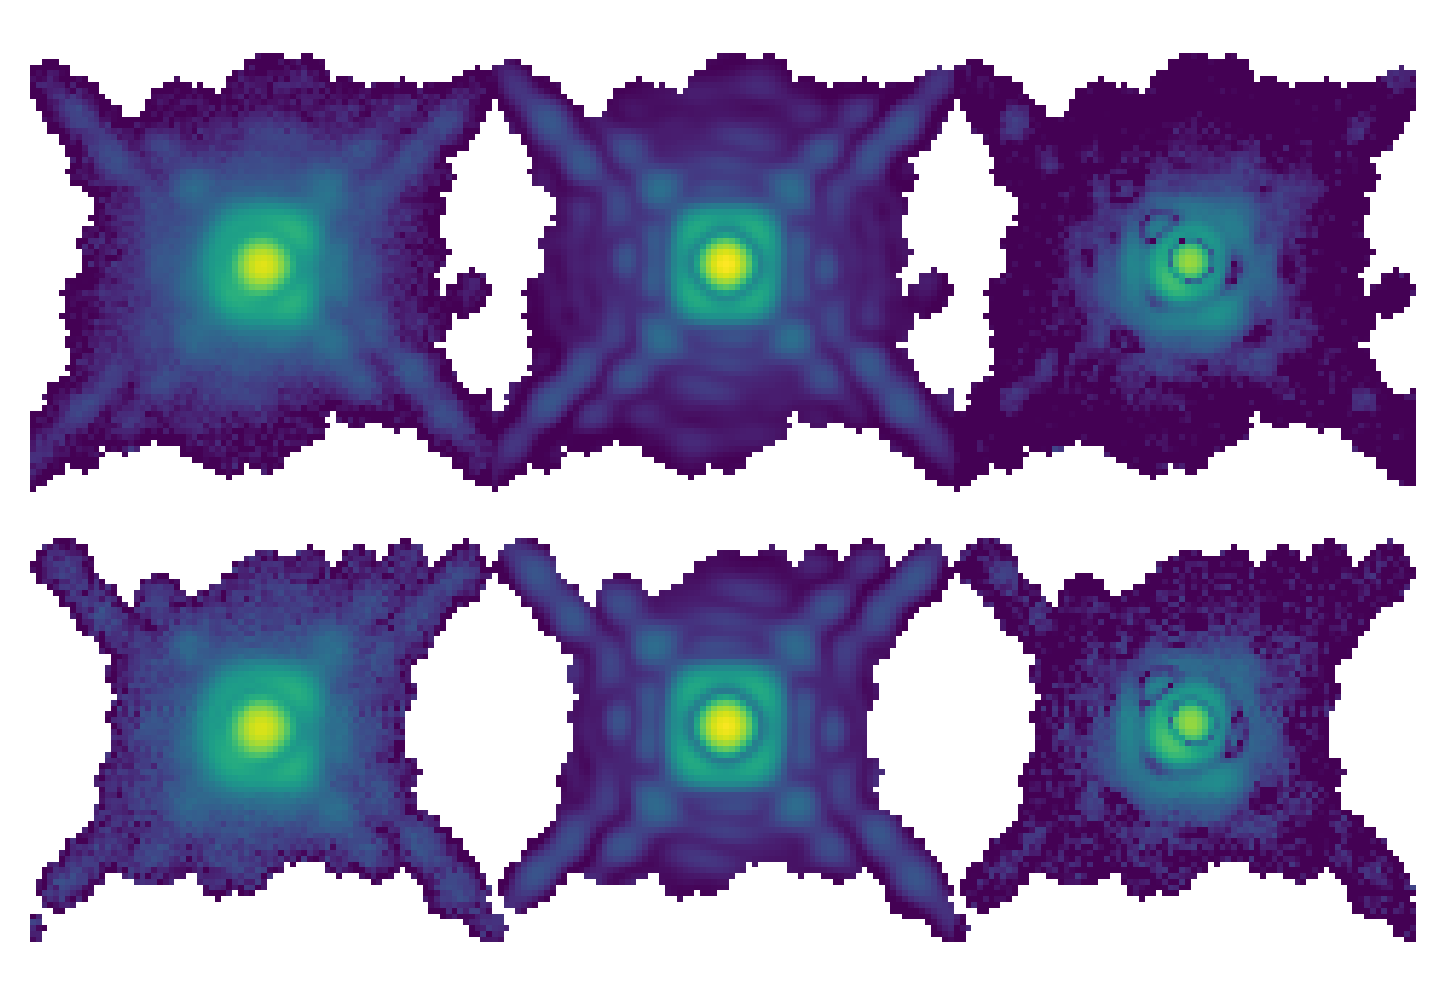

In [6]:
def simulate(x_):
    '''

    '''
    # Note, that every call to model_inputs.unstack() will update the internal state of model_inputs
    # Switching the update off helps to leave the internal state of model_inputs intact
    input_dict = model_inputs.unstack(x_, update=True)
    # PSD = None means that the PSD will be computed inside the model and not provided from outside.
    return model(x=input_dict, PSD=None, phase_generator=lambda: compute_static_phase(input_dict))

x0 = model_inputs.stack()

# Direct prediction without any calibration or fitting, quite inaccurate
PSF_pred = simulate(x0)

draw_PSF_stack(PSF_data*PSF_mask, PSF_pred*PSF_mask, average=True, min_val=1e-5, crop=80, scale='log')


The only purpose of this class is to regularize the optimization of LWE coefficients to avoid overfitting

In [7]:
class LWERegularizer:
    # These initial values are completely empirical
    def __init__(self, device, amplitude=50.0, gaussian_sigma_factor=2.0, gauss_penalty_weight=5.0, l2_weight=1e-4):
        self.device = device
        self.amplitude = amplitude
        self.gaussian_sigma = amplitude / gaussian_sigma_factor
        self.l2_weight = l2_weight
        self.gauss_penalty_weight = gauss_penalty_weight

        # Define patterns to avoid while optimizing because they are unlikely to appear physically and thus may mean overfitting
        pattern_templates = [
            [0,0,0,0,  0,-1,1,0,  1,0,0,-1],  # pattern_outwards
            [0,0,0,0,  0,1,-1,0, -1,0,0, 1],  # pattern_inwards
            [0,0,0,0,  0,-1,1,0, -1,0,0, 1],  # pattern_1
            [0,0,0,0,  0,1,-1,0,  1,0,0,-1],  # pattern_2
            [0,0,0,0,  1,0,0,-1,  0,1,-1,0],  # pattern_3
            [0,0,0,0,  -1,0,0,1,  0,-1,1,0],  # pattern_4
            [-1,1,1,-1,  0,0,0,0,  0,0,0,0],  # pattern_piston_horiz
            [1,-1,-1,1,  0,0,0,0,  0,0,0,0]   # pattern_piston_vert
        ]

        # Create tensor patterns from templates
        self.patterns = [torch.tensor([p]).to(device).float() * self.amplitude for p in pattern_templates]

    def gaussian_penalty(self, amplitude, x, x_0, sigma):
        # Calculate Gaussian penalty between coefficient vector and pattern template
        return amplitude * torch.exp(-torch.sum((x - x_0) ** 2) / (2 * sigma ** 2))

    def pattern_error(self, pattern, coefficients):
        # Calculate error term for a specific pattern
        return (pattern * self.gaussian_penalty(self.gauss_penalty_weight, coefficients, pattern, self.gaussian_sigma)).flatten().abs().sum()

    def __call__(self, coefficients):
        # Calculate the full LWE regularization loss for given coefficients
        pattern_loss = sum(self.pattern_error(pattern, coefficients) for pattern in self.patterns)
        # L2 regularization
        LWE_l2_loss = (coefficients**2).mean() * self.l2_weight

        return pattern_loss + LWE_l2_loss


# Initialize the regularizer
LWE_regularizer = LWERegularizer(device)

L1_loss_custom = lambda x: ( (simulate(x)-PSF_data) * PSF_mask ).flatten().abs().sum()

def loss_fn(x_):
    # You can also update the models_inputs entries directly if needed
    return L1_loss_custom(x_) + LWE_regularizer(model_inputs['LWE_coefs']) * float(model_inputs.is_optimizable('LWE_coefs'))

Do fitting. For this, the optimized model inputs must be first stacked into to a single vector, which is then passassed to the optimizer.

In [8]:
# Switch off optimization of Zernike coefficients for now, so they are not stacked into the model inputs vector
model_inputs.set_optimizable('Z_coefs', False) # Can be done for any variable

x0 = model_inputs.stack()
result = minimize(loss_fn, x0, max_iter=300, tol=1e-5, method='l-bfgs', disp=2)
x0 = result.x

# Simulate PSF with updated parameters after the fitting
PSF_fitted = simulate(x0)

# You back up internal state of the inputs manager
model_inputs_backup = model_inputs.copy()

initial fval: 3.3665
iter   1 - fval: 3.1958
iter   2 - fval: 3.1947
iter   3 - fval: 3.0647
iter   4 - fval: 2.9940
iter   5 - fval: 2.9295
iter   6 - fval: 2.8366
iter   7 - fval: 2.6526
iter   8 - fval: 1.2503
iter   9 - fval: 1.1816
iter  10 - fval: 1.0981
iter  11 - fval: 0.7595
iter  12 - fval: 0.6280
iter  13 - fval: 0.5009
iter  14 - fval: 0.4478
iter  15 - fval: 0.4205
iter  16 - fval: 0.3810
iter  17 - fval: 0.3785
iter  18 - fval: 0.3602
iter  19 - fval: 0.3498
iter  20 - fval: 0.3467
iter  21 - fval: 0.3442
iter  22 - fval: 0.3415
iter  23 - fval: 0.3398
iter  24 - fval: 0.3382
iter  25 - fval: 0.3326
iter  26 - fval: 0.3289
iter  27 - fval: 0.3264
iter  28 - fval: 0.3236
iter  29 - fval: 0.3207
iter  30 - fval: 0.3138
iter  31 - fval: 0.3118
iter  32 - fval: 0.3110
iter  33 - fval: 0.3100
iter  34 - fval: 0.3096
iter  35 - fval: 0.3095
iter  36 - fval: 0.3094
iter  37 - fval: 0.3094
iter  38 - fval: 0.3093
iter  39 - fval: 0.3091
iter  40 - fval: 0.3089
iter  41 - fval: 0.

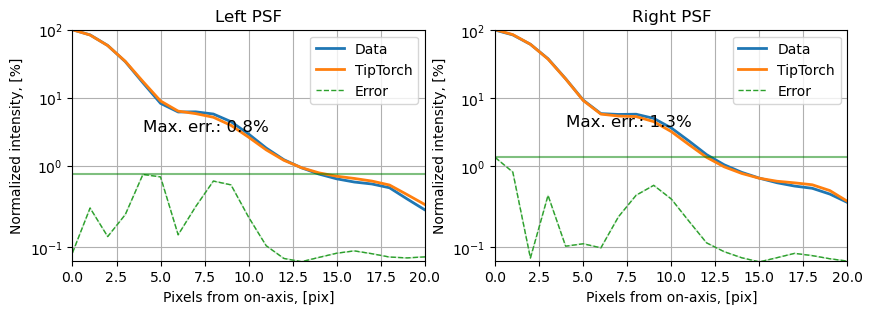

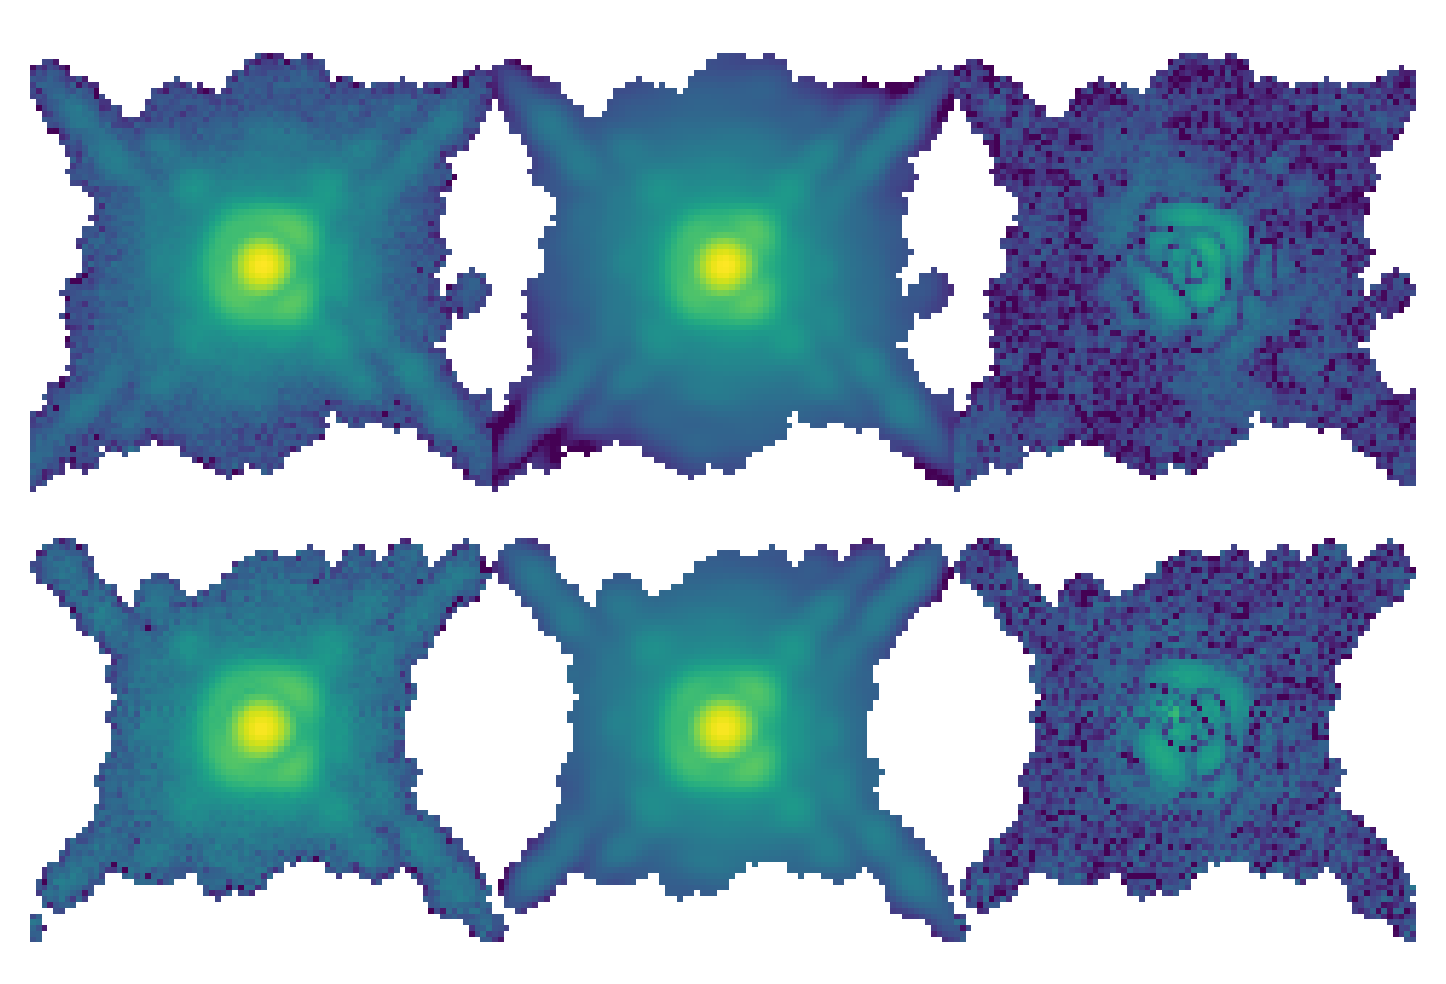

In [9]:
def RenderPSFs(PSF_0, PSF_1, mask=1):
    # Since SPHERE (IRDIS) PSFs have two spectral/polarization channels (L and R), both are rendered simultaneosuly
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    # Draw profiles
    plot_radial_profiles( (PSF_0*mask)[:,0,...].cpu().numpy(), (PSF_1*mask)[:,0,...].cpu().numpy(), 'Data', 'TipTorch', title='Left PSF',  ax=ax[0] )
    plot_radial_profiles( (PSF_0*mask)[:,1,...].cpu().numpy(), (PSF_1*mask)[:,1,...].cpu().numpy(), 'Data', 'TipTorch', title='Right PSF', ax=ax[1] )
    plt.show()
    # Draw images
    draw_PSF_stack(PSF_0*mask, PSF_1*mask, min_val=1e-6, average=True, crop=80)

RenderPSFs(PSF_data, PSF_fitted, PSF_mask)

Now, let's add Zernike modes just because

In [10]:
model_inputs['Z_coefs'][..., 4] = 200 # [nm]
model_inputs['Z_coefs'][..., 2] = 50  # [nm]

PSF_with_defocus = simulate(x0)


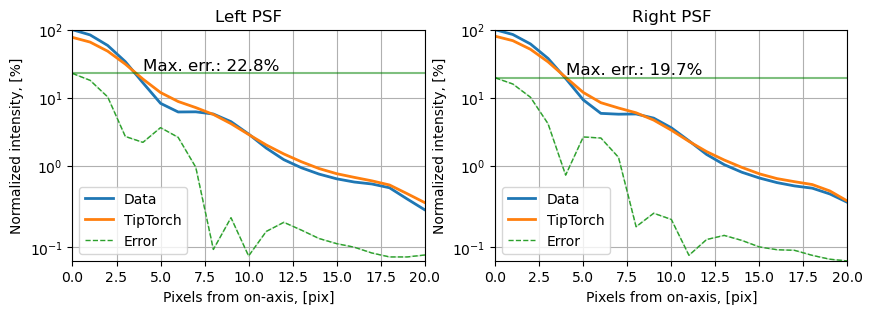

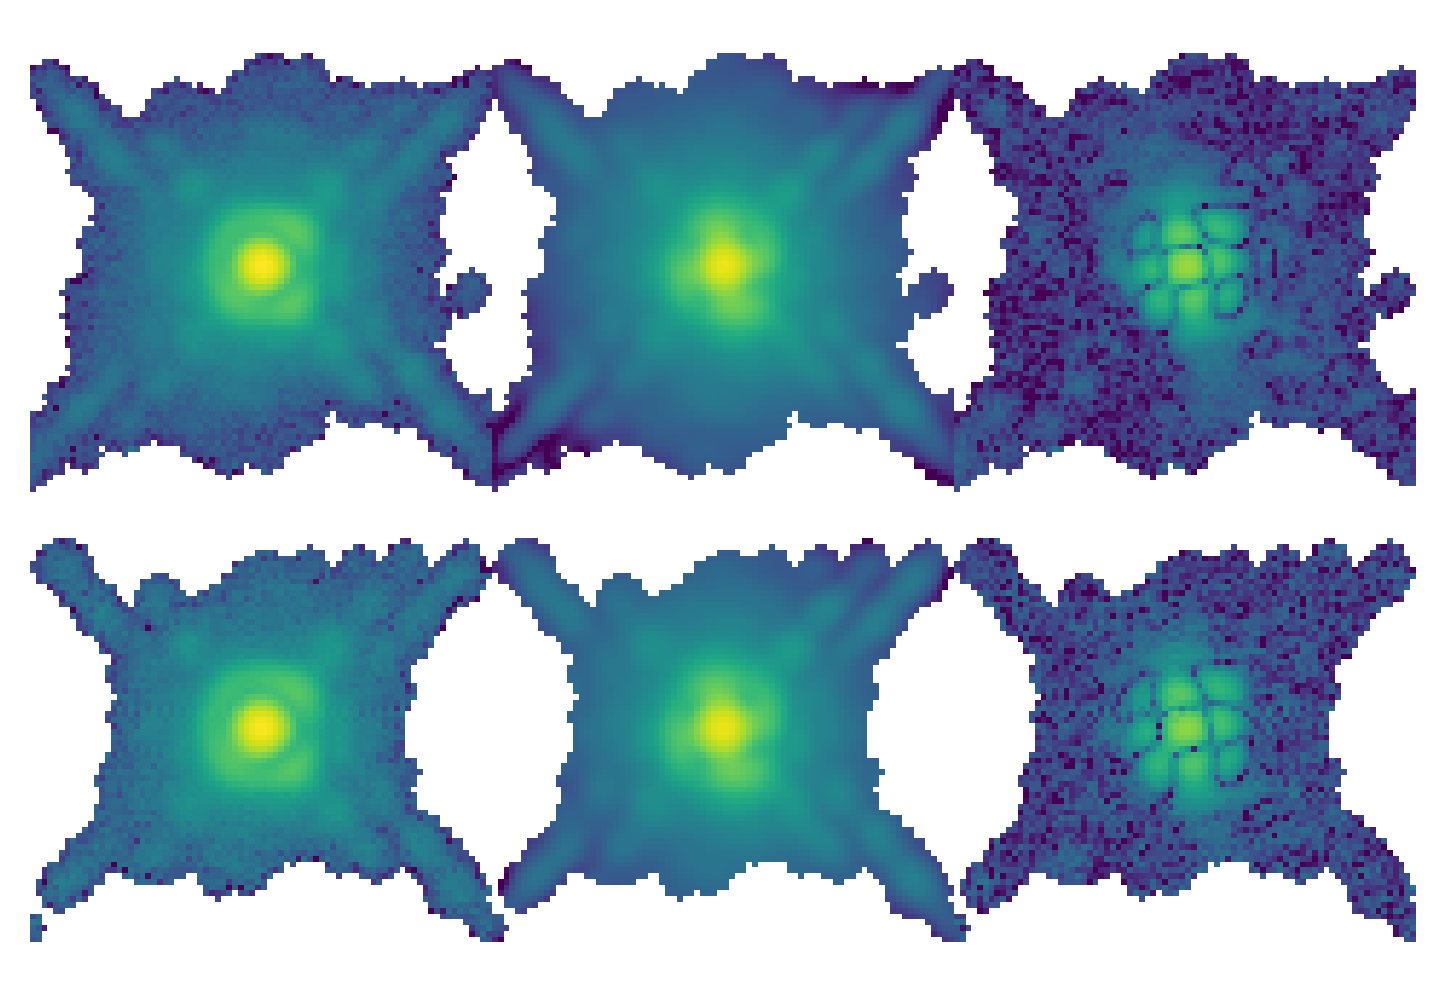

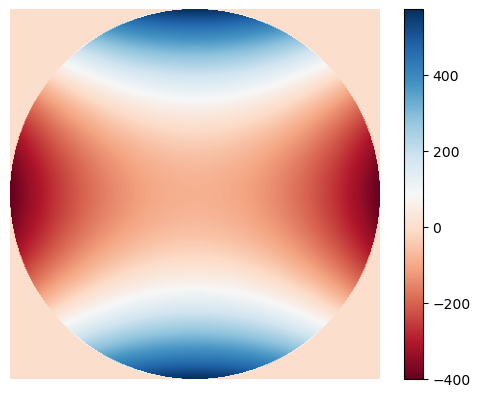

In [11]:
RenderPSFs(PSF_data, PSF_with_defocus, PSF_mask)
plt.show()

OPD_map = Z_basis.compute_OPD(model_inputs['Z_coefs'])[0].detach().cpu().numpy() * 1e9 # [nm]
plt.imshow(OPD_map, cmap='RdBu')
plt.colorbar()
plt.axis('off')
plt.show()